----
### Import Libraries
First, import all the necessary public libraries as well as a few classes from the `torchsig` toolkit. An additional import from the `cm_plotter.py` helper script is also done here to retrieve a function to streamline plotting of confusion matrices.

# Example 02 - Sig53 Classifier
This notebook walks through a simple example of how to use the clean Sig53 dataset, load a pre-trained supported model, and evaluate the trained network's performance. Note that the experiment and the results herein are not to be interpreted with any significant value but rather serve simply as a practical example of how the `torchsig` dataset and tools can be used and integrated within a typical [PyTorch](https://pytorch.org/) and/or [PyTorch Lightning](https://www.pytorchlightning.ai/) workflow.

In [1]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b2, efficientnet_b4, efficientnet_b0
from xcit.xcit import XCiT, xcit_nano,xcit_tiny12

import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import os
import shutil
from torch.utils.data import Subset
from Train_evaluate import *
from sigCustmized import Sig53
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch import nn, optim


In [2]:
selected_classes = [
        "bpsk",
        "qpsk",
        "8psk",
        "16qam",
        "64qam",
        "256qam",
        "ofdm-64",
        "ofdm-72",
        "ofdm-128",
        "ofdm-180",
        "ofdm-256",
        "ofdm-300",
        "ofdm-512",
        "ofdm-600",
        "ofdm-900",
        "ofdm-1024",
        "ofdm-1200",
        "ofdm-2048",
    ]

In [3]:
len(selected_classes)

18

----
### Instantiate Sig53 Dataset
Here, we instantiate the Sig53 clean training dataset and the Sig53 clean validation dataset. We demonstrate how to compose multiple TorchSig transforms together, using a data impairment with a random phase shift that uniformly samples a phase offset between -1 pi and +1 pi. The next transform normalizes the complex tensor, and the final transform converts the complex data to a real-valued tensor with the real and imaginary parts as two channels. We additionally provide a target transform that maps the `SignalDescription` objects, that are part of `SignalData` objects, to a desired format for the model we will train. In this case, we use the `DescToClassIndex` target transform to map class names to their indices within an ordered class list. Finally, we sample from our datasets and print details in order to confirm functionality.

For more details on the Sig53 dataset instantiations, please see the Sig53 example notebook.

In [3]:
# Specify Sig53 Options
root = "../../../../data/torchsig/Cust/"
train = True
impaired = False
class_list = list(Sig53._idx_to_name_dict.values())
transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

# Instantiate the Sig53 Clean Training Dataset
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Instantiate the Sig53 Clean Validation Dataset
train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

# Retrieve a sample and print out information to verify
idx = np.random.randint(len(sig53_clean_train))
data, label = sig53_clean_train[idx]
print("Dataset length: {}".format(len(sig53_clean_train)))
print("Data shape: {}".format(data.shape))
print("Label Index: {}".format(label))
print("Label Class: {}".format(Sig53.convert_idx_to_name(label)))

Dataset length: 1576
Data shape: (2, 4096)
Label Index: 12
Label Class: ofdm-512


----
### Format Dataset for Training
Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

In [4]:
# Calculate the size of the validation set (10% of the training set)
val_size = int(0.1 * len(sig53_clean_train))
train_size = len(sig53_clean_train) - val_size

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = torch.utils.data.random_split(sig53_clean_train, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

----
### Call and Train Model
Loading the model structure to be trained

## Efficientnet B0

In [9]:
model = efficientnet_b0(
    pretrained=False,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



In [10]:
from torch import nn, optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [11]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 8100/8100 [07:24<00:00, 18.21it/s, loss=1.1181, accuracy=51.01%]


Epoch 1: Train Loss 1.1181, Acc 51.01%, Val Loss 0.6098, Val Acc 73.03%
Epoch 2/20


Training: 100%|██████████| 8100/8100 [07:22<00:00, 18.32it/s, loss=0.4914, accuracy=77.23%]


Epoch 2: Train Loss 0.4913, Acc 77.23%, Val Loss 0.4067, Val Acc 80.47%
Epoch 3/20


Training: 100%|██████████| 8100/8100 [07:11<00:00, 18.78it/s, loss=0.3587, accuracy=83.15%]


Epoch 3: Train Loss 0.3587, Acc 83.15%, Val Loss 0.2970, Val Acc 86.01%
Epoch 4/20


Training: 100%|██████████| 8100/8100 [07:10<00:00, 18.79it/s, loss=0.2972, accuracy=86.03%]


Epoch 4: Train Loss 0.2972, Acc 86.03%, Val Loss 0.3232, Val Acc 84.97%
Epoch 5/20


Training: 100%|██████████| 8100/8100 [07:09<00:00, 18.84it/s, loss=0.2661, accuracy=87.74%]


Epoch 5: Train Loss 0.2661, Acc 87.74%, Val Loss 0.1747, Val Acc 92.77%
Epoch 6/20


Training: 100%|██████████| 8100/8100 [07:10<00:00, 18.82it/s, loss=0.2248, accuracy=90.21%]


Epoch 6: Train Loss 0.2247, Acc 90.21%, Val Loss 0.1773, Val Acc 92.31%
Epoch 7/20


Training: 100%|██████████| 8100/8100 [07:09<00:00, 18.84it/s, loss=0.1953, accuracy=91.67%]


Epoch 7: Train Loss 0.1953, Acc 91.67%, Val Loss 0.1493, Val Acc 93.78%
Epoch 8/20


Training: 100%|██████████| 8100/8100 [07:10<00:00, 18.81it/s, loss=0.1767, accuracy=92.45%]


Epoch 8: Train Loss 0.1767, Acc 92.45%, Val Loss 0.2326, Val Acc 89.86%
Epoch 9/20


Training: 100%|██████████| 8100/8100 [07:10<00:00, 18.81it/s, loss=0.1676, accuracy=92.92%]


Epoch 9: Train Loss 0.1676, Acc 92.92%, Val Loss 0.1665, Val Acc 93.01%
Epoch 10/20


Training: 100%|██████████| 8100/8100 [07:10<00:00, 18.83it/s, loss=0.1563, accuracy=93.45%]


Epoch 10: Train Loss 0.1563, Acc 93.45%, Val Loss 0.2071, Val Acc 91.35%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


Validation Loss: 0.1493
Validation Accuracy: 93.78%


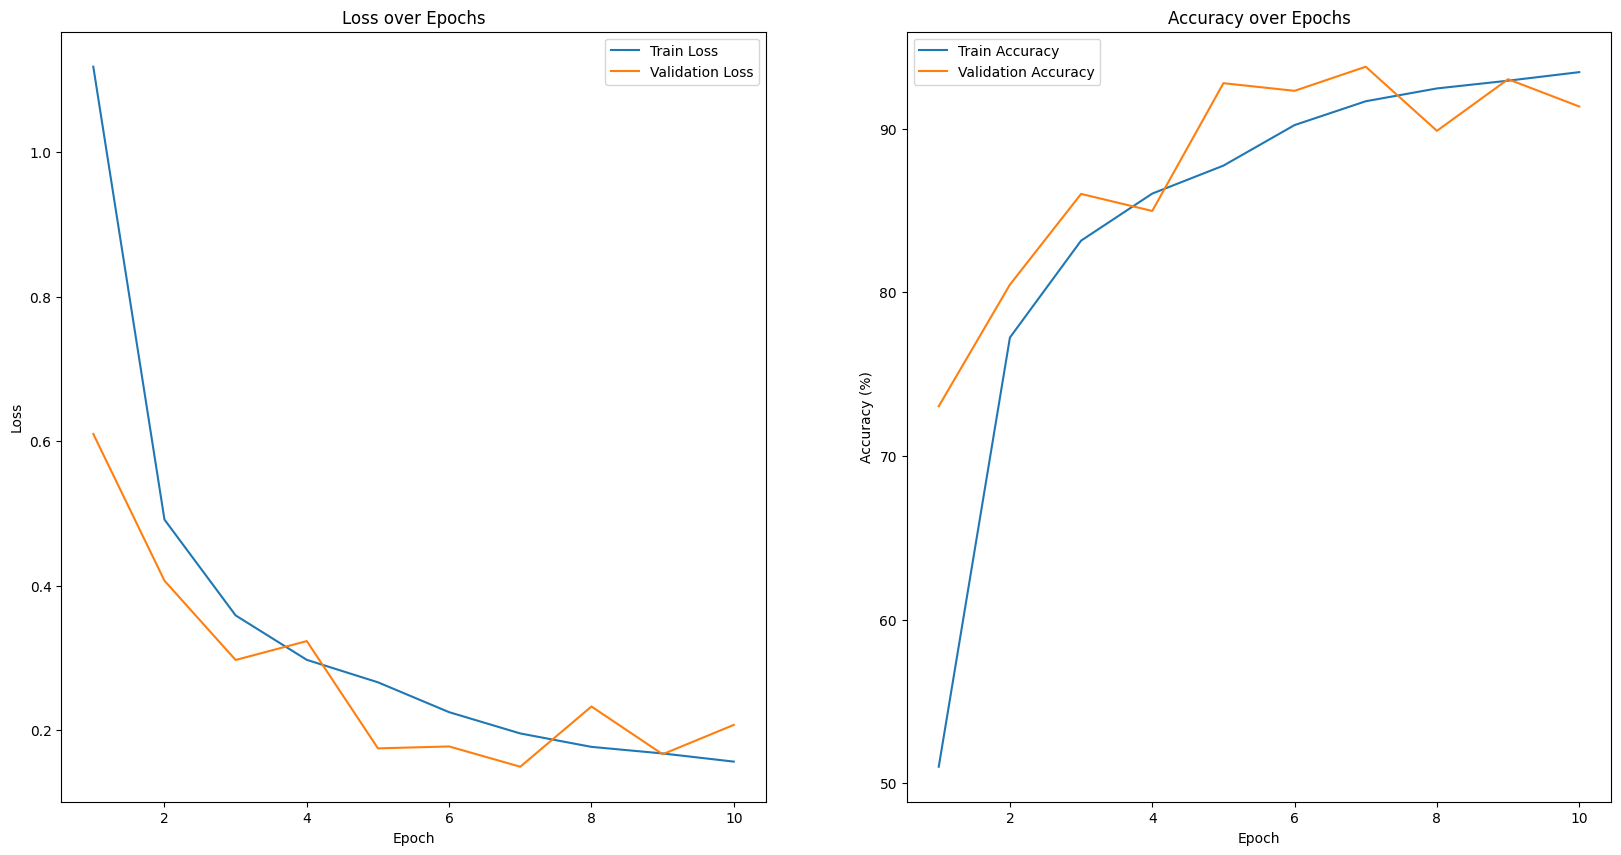

<Figure size 1500x1500 with 0 Axes>

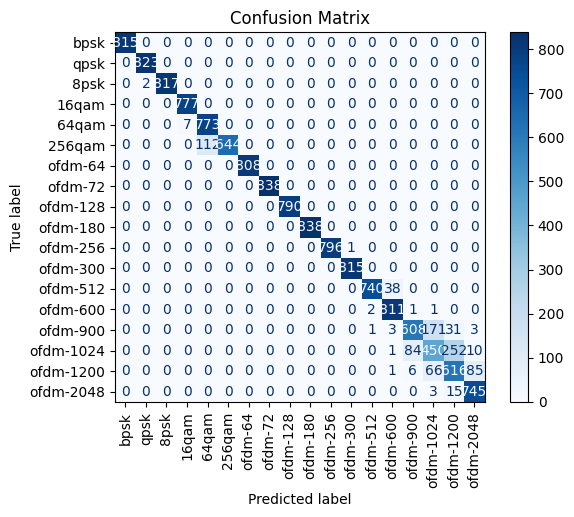

In [12]:
val_loss, val_accuracy, labels, predictions = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)


plot_metrics_and_confusion_matrix(trainer, labels, predictions,selected_classes)

In [13]:

report = classification_report(labels, predictions, target_names=selected_classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        bpsk       1.00      1.00      1.00       815
        qpsk       1.00      1.00      1.00       823
        8psk       1.00      1.00      1.00       819
       16qam       0.99      1.00      1.00       777
       64qam       0.87      0.99      0.93       780
      256qam       1.00      0.85      0.92       756
     ofdm-64       1.00      1.00      1.00       808
     ofdm-72       1.00      1.00      1.00       838
    ofdm-128       1.00      1.00      1.00       790
    ofdm-180       1.00      1.00      1.00       838
    ofdm-256       1.00      1.00      1.00       797
    ofdm-300       1.00      1.00      1.00       815
    ofdm-512       1.00      0.95      0.97       778
    ofdm-600       0.95      1.00      0.97       815
    ofdm-900       0.87      0.74      0.80       817
   ofdm-1024       0.65      0.56      0.60       797
   ofdm-1200       0.67      0.80      0.73       774
   o

## Efficientnet B2

In [6]:
model = efficientnet_b2(
    pretrained=False,
    path="efficientnet_b2.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [6]:
from torch import nn, optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [8]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 8100/8100 [09:29<00:00, 14.23it/s, loss=1.4117, accuracy=40.58%]


Epoch 1: Train Loss 1.4117, Acc 40.58%, Val Loss 1.0270, Val Acc 56.38%
Epoch 2/20


Training: 100%|██████████| 8100/8100 [09:50<00:00, 13.71it/s, loss=0.9945, accuracy=57.95%]


Epoch 2: Train Loss 0.9945, Acc 57.95%, Val Loss 0.8793, Val Acc 62.47%
Epoch 3/20


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.27it/s, loss=0.8731, accuracy=63.27%]


Epoch 3: Train Loss 0.8731, Acc 63.27%, Val Loss 0.8134, Val Acc 65.27%
Epoch 4/20


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.26it/s, loss=0.7491, accuracy=67.96%]


Epoch 4: Train Loss 0.7491, Acc 67.96%, Val Loss 0.6196, Val Acc 72.53%
Epoch 5/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.29it/s, loss=0.6482, accuracy=71.61%]


Epoch 5: Train Loss 0.6482, Acc 71.61%, Val Loss 0.5905, Val Acc 74.20%
Epoch 6/20


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.26it/s, loss=0.6103, accuracy=73.76%]


Epoch 6: Train Loss 0.6103, Acc 73.76%, Val Loss 0.5222, Val Acc 78.33%
Epoch 7/20


Training: 100%|██████████| 8100/8100 [10:08<00:00, 13.30it/s, loss=0.5709, accuracy=76.23%]


Epoch 7: Train Loss 0.5709, Acc 76.23%, Val Loss 0.4731, Val Acc 80.72%
Epoch 8/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.30it/s, loss=0.5224, accuracy=78.43%]


Epoch 8: Train Loss 0.5224, Acc 78.43%, Val Loss 0.4579, Val Acc 81.49%
Epoch 9/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.29it/s, loss=0.4964, accuracy=79.65%]


Epoch 9: Train Loss 0.4964, Acc 79.65%, Val Loss 0.4684, Val Acc 80.78%
Epoch 10/20


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.27it/s, loss=0.4801, accuracy=80.36%]


Epoch 10: Train Loss 0.4801, Acc 80.36%, Val Loss 0.4484, Val Acc 81.88%
Epoch 11/20


Training: 100%|██████████| 8100/8100 [10:08<00:00, 13.32it/s, loss=0.4667, accuracy=80.92%]


Epoch 11: Train Loss 0.4667, Acc 80.92%, Val Loss 0.4300, Val Acc 82.56%
Epoch 12/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.28it/s, loss=0.4561, accuracy=81.50%]


Epoch 12: Train Loss 0.4561, Acc 81.50%, Val Loss 0.4062, Val Acc 83.74%
Epoch 13/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.29it/s, loss=0.4463, accuracy=81.83%]


Epoch 13: Train Loss 0.4463, Acc 81.83%, Val Loss 0.4023, Val Acc 83.78%
Epoch 14/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.29it/s, loss=0.4389, accuracy=82.15%]


Epoch 14: Train Loss 0.4389, Acc 82.15%, Val Loss 0.4431, Val Acc 81.95%
Epoch 15/20


Training: 100%|██████████| 8100/8100 [10:14<00:00, 13.19it/s, loss=0.4313, accuracy=82.47%]


Epoch 15: Train Loss 0.4313, Acc 82.47%, Val Loss 0.3842, Val Acc 85.01%
Epoch 16/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.29it/s, loss=0.4230, accuracy=82.92%]


Epoch 16: Train Loss 0.4230, Acc 82.92%, Val Loss 0.3947, Val Acc 83.97%
Epoch 17/20


Training: 100%|██████████| 8100/8100 [10:08<00:00, 13.30it/s, loss=0.4151, accuracy=83.11%]


Epoch 17: Train Loss 0.4151, Acc 83.11%, Val Loss 0.3764, Val Acc 84.80%
Epoch 18/20


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.28it/s, loss=0.3384, accuracy=85.80%]


Epoch 18: Train Loss 0.3384, Acc 85.80%, Val Loss 0.2543, Val Acc 88.76%
Epoch 19/20


Training: 100%|██████████| 8100/8100 [10:11<00:00, 13.25it/s, loss=0.2229, accuracy=90.36%]


Epoch 19: Train Loss 0.2229, Acc 90.36%, Val Loss 0.4364, Val Acc 83.39%
Epoch 20/20


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.27it/s, loss=0.1836, accuracy=92.08%]


Epoch 20: Train Loss 0.1836, Acc 92.08%, Val Loss 0.1599, Val Acc 93.26%
Loaded best model from best_model_checkpoint.pth


In [9]:
trainer.run_training_loop(num_epochs=10)

Epoch 1/10


Training: 100%|██████████| 8100/8100 [10:09<00:00, 13.28it/s, loss=0.1662, accuracy=92.88%]


Epoch 1: Train Loss 0.1662, Acc 92.88%, Val Loss 0.1304, Val Acc 94.19%
Epoch 2/10


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.27it/s, loss=0.1511, accuracy=93.58%]


Epoch 2: Train Loss 0.1511, Acc 93.58%, Val Loss 0.1864, Val Acc 92.13%
Epoch 3/10


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.27it/s, loss=0.1380, accuracy=94.14%]


Epoch 3: Train Loss 0.1380, Acc 94.14%, Val Loss 0.3386, Val Acc 88.40%
Epoch 4/10


Training: 100%|██████████| 8100/8100 [10:10<00:00, 13.27it/s, loss=0.1307, accuracy=94.55%]


Epoch 4: Train Loss 0.1307, Acc 94.55%, Val Loss 0.1964, Val Acc 91.72%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


Validation Loss: 0.1304
Validation Accuracy: 94.19%


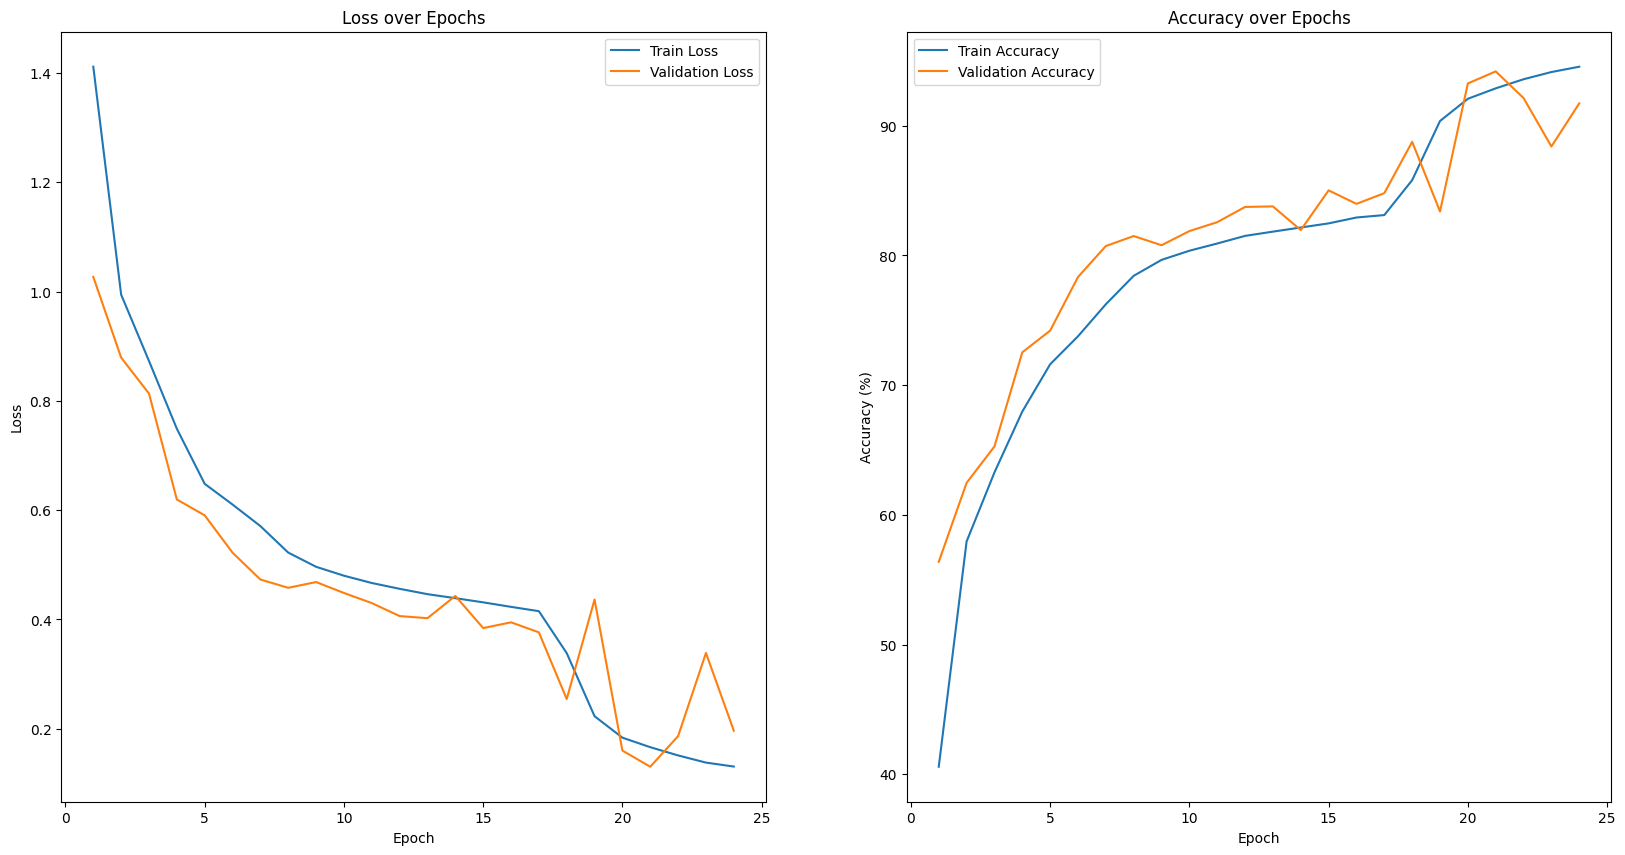

<Figure size 1500x1500 with 0 Axes>

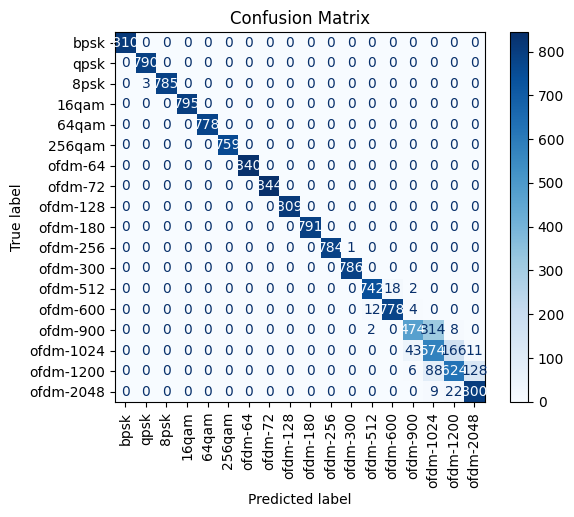

In [13]:
val_loss, val_accuracy, labels, predictions = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)


plot_metrics_and_confusion_matrix(trainer, labels, predictions,selected_classes)

In [14]:

report = classification_report(labels, predictions, target_names=selected_classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        bpsk       1.00      1.00      1.00       810
        qpsk       1.00      1.00      1.00       790
        8psk       1.00      1.00      1.00       788
       16qam       1.00      1.00      1.00       795
       64qam       1.00      1.00      1.00       778
      256qam       1.00      1.00      1.00       759
     ofdm-64       1.00      1.00      1.00       840
     ofdm-72       1.00      1.00      1.00       844
    ofdm-128       1.00      1.00      1.00       809
    ofdm-180       1.00      1.00      1.00       791
    ofdm-256       1.00      1.00      1.00       785
    ofdm-300       1.00      1.00      1.00       786
    ofdm-512       0.98      0.97      0.98       762
    ofdm-600       0.98      0.98      0.98       794
    ofdm-900       0.90      0.59      0.71       798
   ofdm-1024       0.58      0.72      0.65       794
   ofdm-1200       0.76      0.74      0.75       846
   o

## EfficientNet B4

In [15]:
model = efficientnet_b4(
    pretrained=False,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

In [17]:
trainer = ModelTrainer(model, train_dataloader, val_dataloader, criterion, optimizer, device)
trainer.run_training_loop(num_epochs)

Epoch 1/20


Training: 100%|██████████| 8100/8100 [17:17<00:00,  7.81it/s, loss=1.4649, accuracy=38.78%]


Epoch 1: Train Loss 1.4649, Acc 38.78%, Val Loss 1.0414, Val Acc 56.34%
Epoch 2/20


Training: 100%|██████████| 8100/8100 [19:25<00:00,  6.95it/s, loss=0.9918, accuracy=58.19%]


Epoch 2: Train Loss 0.9918, Acc 58.19%, Val Loss 0.8360, Val Acc 64.81%
Epoch 3/20


Training: 100%|██████████| 8100/8100 [19:53<00:00,  6.79it/s, loss=0.8635, accuracy=63.72%]


Epoch 3: Train Loss 0.8635, Acc 63.72%, Val Loss 0.7261, Val Acc 69.11%
Epoch 4/20


Training: 100%|██████████| 8100/8100 [18:09<00:00,  7.44it/s, loss=0.7667, accuracy=67.51%]


Epoch 4: Train Loss 0.7667, Acc 67.51%, Val Loss 0.6981, Val Acc 70.69%
Epoch 5/20


Training: 100%|██████████| 8100/8100 [17:09<00:00,  7.87it/s, loss=0.7332, accuracy=69.13%]


Epoch 5: Train Loss 0.7332, Acc 69.13%, Val Loss 0.6648, Val Acc 71.21%
Epoch 6/20


Training: 100%|██████████| 8100/8100 [17:17<00:00,  7.81it/s, loss=0.7055, accuracy=70.45%]


Epoch 6: Train Loss 0.7055, Acc 70.45%, Val Loss 0.6618, Val Acc 72.25%
Epoch 7/20


Training: 100%|██████████| 8100/8100 [17:16<00:00,  7.82it/s, loss=0.6828, accuracy=71.46%]


Epoch 7: Train Loss 0.6828, Acc 71.46%, Val Loss 0.6374, Val Acc 73.65%
Epoch 8/20


Training: 100%|██████████| 8100/8100 [17:17<00:00,  7.81it/s, loss=0.6642, accuracy=72.47%]


Epoch 8: Train Loss 0.6642, Acc 72.47%, Val Loss 0.6181, Val Acc 73.74%
Epoch 9/20


Training: 100%|██████████| 8100/8100 [17:18<00:00,  7.80it/s, loss=0.6263, accuracy=74.77%]


Epoch 9: Train Loss 0.6263, Acc 74.77%, Val Loss 0.5763, Val Acc 76.92%
Epoch 10/20


Training: 100%|██████████| 8100/8100 [17:16<00:00,  7.81it/s, loss=0.5776, accuracy=76.99%]


Epoch 10: Train Loss 0.5776, Acc 76.99%, Val Loss 0.5430, Val Acc 78.17%
Epoch 11/20


Training: 100%|██████████| 8100/8100 [17:14<00:00,  7.83it/s, loss=0.5630, accuracy=77.63%]


Epoch 11: Train Loss 0.5630, Acc 77.63%, Val Loss 0.5139, Val Acc 79.53%
Epoch 12/20


Training: 100%|██████████| 8100/8100 [17:16<00:00,  7.81it/s, loss=0.5527, accuracy=78.22%]


Epoch 12: Train Loss 0.5527, Acc 78.22%, Val Loss 0.5382, Val Acc 78.42%
Epoch 13/20


Training: 100%|██████████| 8100/8100 [17:17<00:00,  7.81it/s, loss=0.5431, accuracy=78.42%]


Epoch 13: Train Loss 0.5431, Acc 78.42%, Val Loss 0.5255, Val Acc 79.23%
Epoch 14/20


Training: 100%|██████████| 8100/8100 [17:19<00:00,  7.79it/s, loss=0.5372, accuracy=78.83%]


Epoch 14: Train Loss 0.5372, Acc 78.83%, Val Loss 0.5069, Val Acc 79.85%
Epoch 15/20


Training: 100%|██████████| 8100/8100 [17:18<00:00,  7.80it/s, loss=0.5273, accuracy=79.13%]


Epoch 15: Train Loss 0.5273, Acc 79.13%, Val Loss 0.4933, Val Acc 80.09%
Epoch 16/20


Training: 100%|██████████| 8100/8100 [17:18<00:00,  7.80it/s, loss=0.5205, accuracy=79.35%]


Epoch 16: Train Loss 0.5205, Acc 79.35%, Val Loss 0.4841, Val Acc 81.08%
Epoch 17/20


Training: 100%|██████████| 8100/8100 [17:17<00:00,  7.80it/s, loss=0.5176, accuracy=79.55%]


Epoch 17: Train Loss 0.5176, Acc 79.55%, Val Loss 0.4792, Val Acc 80.78%
Epoch 18/20


Training: 100%|██████████| 8100/8100 [17:15<00:00,  7.82it/s, loss=0.5092, accuracy=79.79%]


Epoch 18: Train Loss 0.5092, Acc 79.79%, Val Loss 0.4903, Val Acc 80.56%
Epoch 19/20


Training: 100%|██████████| 8100/8100 [17:18<00:00,  7.80it/s, loss=0.5061, accuracy=79.91%]


Epoch 19: Train Loss 0.5061, Acc 79.91%, Val Loss 0.4847, Val Acc 80.72%
Stopping early due to no improvement in validation accuracy.
Loaded best model from best_model_checkpoint.pth


Validation Loss: 0.4841
Validation Accuracy: 81.08%


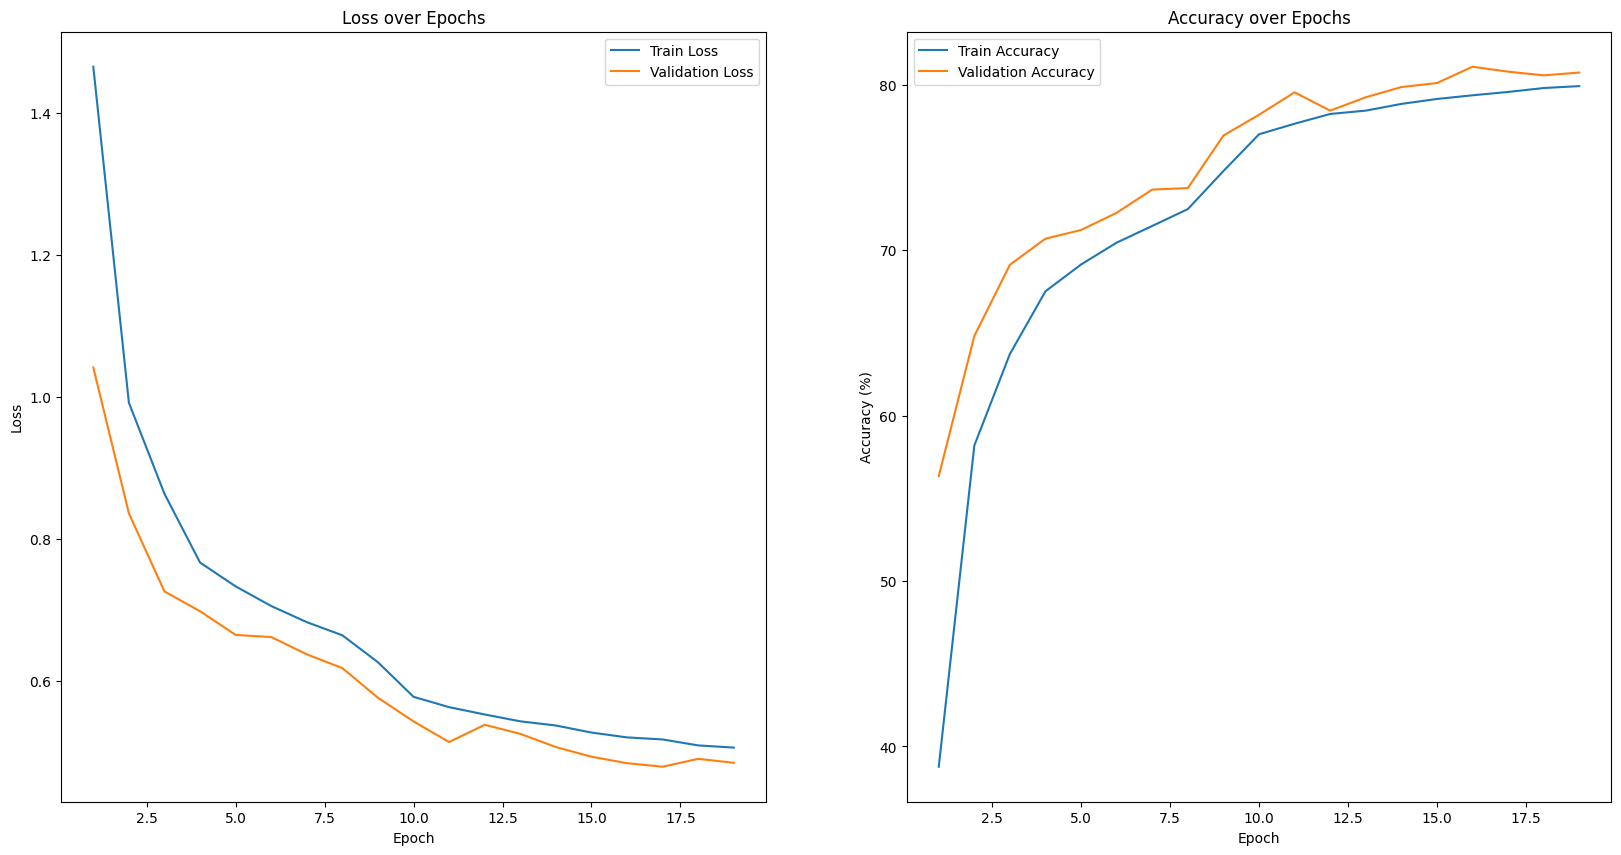

<Figure size 1500x1500 with 0 Axes>

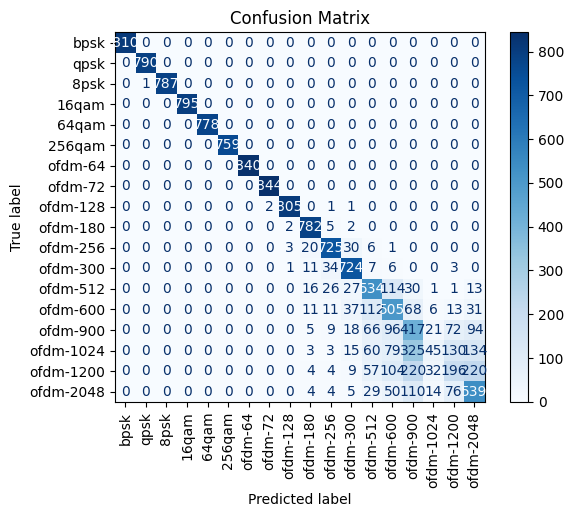

In [18]:
# Evaluate the model
val_loss, val_accuracy, labels, predictions = evaluate_model(trainer.model, trainer.val_dataloader, trainer.criterion, trainer.device)

plot_metrics_and_confusion_matrix(trainer, labels, predictions, selected_classes)

## Pretrained test

In [17]:
default_classes= [
        "ook",
        "bpsk",
        "4pam",
        "4ask",
        "qpsk",
        "8pam",
        "8ask",
        "8psk",
        "16qam",
        "16pam",
        "16ask",
        "16psk",
        "32qam",
        "32qam_cross",
        "32pam",
        "32ask",
        "32psk",
        "64qam",
        "64pam",
        "64ask",
        "64psk",
        "128qam_cross",
        "256qam",
        "512qam_cross",
        "1024qam",
        "2fsk",
        "2gfsk",
        "2msk",
        "2gmsk",
        "4fsk",
        "4gfsk",
        "4msk",
        "4gmsk",
        "8fsk",
        "8gfsk",
        "8msk",
        "8gmsk",
        "16fsk",
        "16gfsk",
        "16msk",
        "16gmsk",
        "ofdm-64",
        "ofdm-72",
        "ofdm-128",
        "ofdm-180",
        "ofdm-256",
        "ofdm-300",
        "ofdm-512",
        "ofdm-600",
        "ofdm-900",
        "ofdm-1024",
        "ofdm-1200",
        "ofdm-2048",
    ]

In [28]:
class_list = default_classes

transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

train = False
sig53_clean_val = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

In [29]:
test_dataloader = DataLoader(
    dataset=sig53_clean_val,
    batch_size=32,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

In [50]:
model = efficientnet_b0(
    pretrained=True,
    path="efficientnet_b0.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [51]:
results = evaluate_model(model, test_dataloader, criterion, device)

Validation Loss: 0.5281
Validation Accuracy: 77.18%
Average Inference Time per Batch: 0.0601 seconds


In [ ]:
model = efficientnet_b2(
    pretrained=True,
    path="efficientnet_b2.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [43]:
results = evaluate_model(model, test_dataloader, criterion, device)

Validation Loss: 0.3568
Validation Accuracy: 85.57%
Average Inference Time per Batch: 0.0887 seconds


In [52]:
model = efficientnet_b4(
    pretrained=True,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [53]:
results = evaluate_model(model, test_dataloader, criterion, device)

Validation Loss: 0.0860
Validation Accuracy: 97.02%
Average Inference Time per Batch: 0.1560 seconds


In [54]:
model = xcit_nano(
    pretrained=True,
    path="xcit_nano.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [57]:
results = evaluate_model(model, test_dataloader, criterion, device)

Validation Loss: 0.0986
Validation Accuracy: 96.78%
Average Inference Time per Batch: 0.2874 seconds


In [58]:
model = xcit_tiny12(
    pretrained=True,
    path="xcit_tiny12.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()

Downloading...
From: https://drive.google.com/uc?id=1DKd5E3WwEZxt99qCeSIzvgc1AWEEfdue
To: /home/mutaz/torchsig/gradiant/xcit_tiny12.pt
100%|██████████| 25.6M/25.6M [00:01<00:00, 23.2MB/s]


In [59]:
results = evaluate_model(model, test_dataloader, criterion, device)

Validation Loss: 0.0557
Validation Accuracy: 98.03%
Average Inference Time per Batch: 0.4634 seconds


In [69]:
def prepare(model_type, batch_size, device_type):
    # Load the specified model
    if model_type == "xcit_nano":
        model = xcit_nano(
            pretrained=True,
            path="xcit_nano.pt",
        )
    elif model_type == "xcit_tiny12":
        model = xcit_tiny12(
            pretrained=True,
            path="xcit_tiny.pt",
        )


    # Create DataLoader with specified dataset and batch size
    test_dataloader = DataLoader(
        dataset=sig53_clean_train,
        batch_size=batch_size,
        num_workers=8,
        shuffle=False,
        drop_last=True,
    )

    # Move model to specified device (cuda or cpu)
    device = torch.device(device_type)
    model = model.to(device)

    return model, test_dataloader, device

criterion = nn.CrossEntropyLoss()


In [68]:
class_list = default_classes

transform = ST.Compose([
    ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
target_transform = ST.DescToClassIndex(class_list=class_list)

train = True
sig53_clean_train = Sig53(
    root=root,
    train=train,
    impaired=impaired,
    transform=transform,
    target_transform=target_transform,
    use_signal_data=True,
)

In [70]:
batch_sizes = [2,4,8,16,32,64,128]
models = ["xcit_nano","xcit_tiny12"]
devices = ['cuda', 'cpu']

for model_type in models:
    for batch_size in batch_sizes:
        for device_type in devices:
            print("model is", model_type)
            print("batch size is", batch_size)
            print("device is", device_type)

            model, test_dataloader, device = prepare(model_type, batch_size, device_type)

            evaluate_model(model, test_dataloader, criterion, device)

model is xcit_nano
batch size is 2
device is cuda
Validation Loss: 0.0982
Validation Accuracy: 96.57%
Average Inference Time per Batch: 0.0320 seconds
model is xcit_nano
batch size is 2
device is cpu
Validation Loss: 0.0982
Validation Accuracy: 96.57%
Average Inference Time per Batch: 0.7408 seconds
model is xcit_nano
batch size is 4
device is cuda
Validation Loss: 0.0977
Validation Accuracy: 96.57%
Average Inference Time per Batch: 0.0421 seconds
model is xcit_nano
batch size is 4
device is cpu
Validation Loss: 0.0977
Validation Accuracy: 96.57%
Average Inference Time per Batch: 1.0806 seconds
model is xcit_nano
batch size is 8
device is cuda
Validation Loss: 0.0972
Validation Accuracy: 96.57%
Average Inference Time per Batch: 0.0879 seconds
model is xcit_nano
batch size is 8
device is cpu
Validation Loss: 0.0972
Validation Accuracy: 96.57%
Average Inference Time per Batch: 1.6507 seconds
model is xcit_nano
batch size is 16
device is cuda
Validation Loss: 0.0987
Validation Accuracy: 9

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 15.75 GiB total capacity; 1.44 GiB already allocated; 581.56 MiB free; 1.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF